# CWN temporal evolution

* In this notebook a set of frames is generated for the ego network of a collector (Munhoz, CBR)

In [1]:
# Setting paths
import sys,os
import pathlib
sys.path.insert(0,os.path.expanduser('~/caryocar'))
sys.path.insert(0,os.path.abspath('..'))

In [2]:
# Building the networks from data
from setupmodels import *

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib as mpl
import seaborn as sns
import scipy as scp 

import matplotlib.pyplot as plt


from matplotlib.colors import to_hex
from collections import Counter

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('seaborn-paper')
sns.set_color_codes('deep')

In [4]:
# plot style params
sns.set_color_codes('deep')
plt.rc('figure', figsize=(16,16))

---

### Define globals

In [5]:
# Globals
OCCS = occs # occurrences
CWN = cwn # the entire CWN 
NI = ni # names index
NM = nm # names map

# Global pd Series
OCCS['eventDate'] = pd.to_datetime(OCCS['eventDate'])
RECORDS_DATES = OCCS['eventDate'].sort_values() # dataset with row ids and event dates
RECORDS_DATES.index.name='id'

TEAMS_TS = OCCS.set_index(['eventDate'])
TEAMS_TS.sort_index(inplace=True)
TEAMS_TS = TEAMS_TS['recordedBy_atomized']

# Helper expressions
get_col_numrecs_upto = lambda col,year: (RECORDS_DATES[NI[col]].dropna()<=str(year)).sum()

def getNodesAndEdgesDuring(cwn, yslice):
    g = CoworkingNetwork(cliques=TEAMS_TS[yslice],namesMap=NM)
    g.remove_nodes_from( set(g.nodes()) - set(cwn.nodes()) ) 
    edges = list(g.edges(data=True))
    nodes = list(g.nodes(data=True))
    del g
    return nodes, edges

### Read graphml file from gephi

In [6]:
cwn = nx.read_graphml(path='graphs/cwn_communities.graphml')

### Custom functions

In [7]:
def buildFramesData(cwn, yearsSlices):
    framesData = dict()
    
    for i,yslice in enumerate(yearsSlices):
        framesData[i]=dict()
        framesData[i]['yslice'] = yslice
        framesData[i]['cols_count_cumulative'] = dict( (col, get_col_numrecs_upto(col,yslice.stop)) for col in cwn.nodes() )
        framesData[i]['nodes'], framesData[i]['edges'] = getNodesAndEdgesDuring(cwn,yslice)

    return framesData

In [8]:
def renderFrame(cwn,fdata,ax=None):

    d = cwn.nodes(data=True) # dict of data of the cwn read
    
    nodes_data = fdata['nodes']
    edges_data = fdata['edges']
    nodes = [ n for n,d in nodes_data]
    edges = [ (u,v) for u,v,d in edges_data ]
    
    pos = dict( ( col, np.array([d[col]['x'],d[col]['y']],dtype=np.float32) ) for col in cwn.nodes() )
    colors = dict( ( col,to_hex(np.array([d[col]['r'], d[col]['g'], d[col]['b']])/255) ) for col in nodes )
    
    xs, ys = list(zip(*pos.values()))
    minx, maxx, miny, maxy =  min(xs), max(xs), min(ys), max(ys)
   
    # Draw nodes
    if len(nodes)>0:
        nodes,nodecolors,nodesizes = zip(*[ (col,colors[col],fdata['cols_count_cumulative'][col]) for col in nodes ])
        scale = lambda x: 1 + x*.03
        nx.draw_networkx_nodes(cwn,pos,nodelist=nodes, node_color=nodecolors,node_size=list(map(scale,nodesizes)),ax=ax)

    
    # Draw edges
    if len(edges)>0:
        scale = lambda x:  0.01 + x*0.01
        edges, weights = zip(*[ ((u,v),d['weight_hyperbolic']) for u,v,d in edges_data ])
        nx.draw_networkx_edges(cwn,pos,edgelist=edges,width=list(map(scale,weights)),ax=ax)
        
        
    # If ax is provided
    if ax is not None:
        ax.set_xlim((minx-100,maxx+100))
        ax.set_ylim((miny-100,maxy+100))
        ax.set_title("{} - {}".format( fdata['yslice'].start, fdata['yslice'].stop ))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    
    #plt.savefig(f'anim/frame{i}.png')
    #plt.clf()

In [9]:
# Define years slices
min_year=1950
max_year=max(RECORDS_DATES)
freq='8A'

years = pd.period_range(start=min_year,end=max_year,freq=freq)
slices = [ slice( str(years[i-1].year), str(years[i].year-1)) for i in range(1,len(years)) ]
#slices.append(slice( str(years[-1].year), str(years[-1].year)))
slices.append(slice('2014','2017'))

In [10]:
fd = buildFramesData(cwn,slices)

In [13]:
def generateGridFig(cwn,slices):
    f,axes = plt.subplots(3,3)
    f.subplots_adjust(wspace=6e-2)
    f.subplots_adjust(hspace=1e-1)
    axes = [ ax for axlist in axes for ax in axlist ]
    
    for i,frame in fd.items():
        renderFrame(cwn,fd[i],ax=axes[i])
        
    return f
    

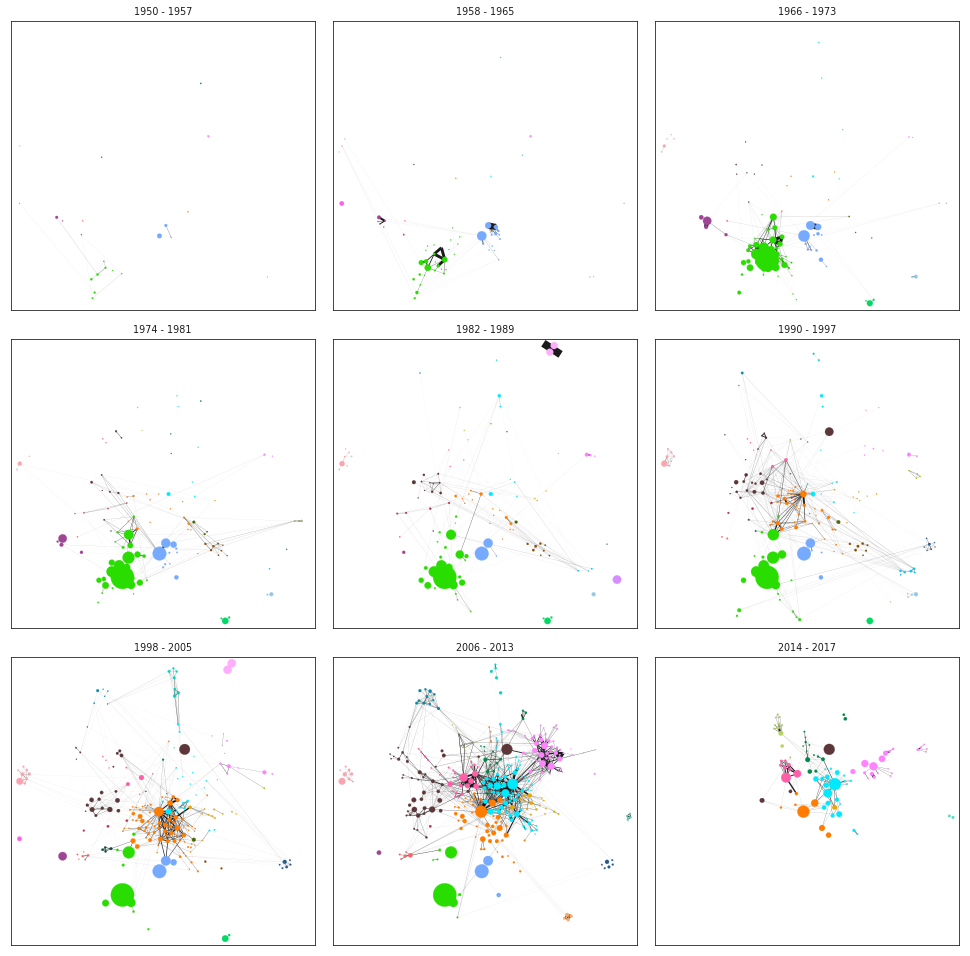

In [15]:
plt.rc('figure', figsize=(17,17))
f = generateGridFig(cwn,slices)

In [16]:
f.savefig('cwn_temporal_evol.png',dpi=200, bbox_inches='tight')